In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'

2023-07-12 10:34:39.159885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

[Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) data is loaded using `keras.datasets`.  
The dataset consists of both training and testing sets. There are 60,000 images for training and 10,000 for testing.  

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")

Shape of training data: (60000, 28, 28)
Shape of testing data: (10000, 28, 28)


As the label in the train and test sets are 0-9 integers, we need to create a `category_list` for lookup between the integer labels and the true category in text.  
<br>
Based on the dataset description, the labels of the categories are as follows:

| Category | Label |
|:-|:-:|
|T-shirt/Top|0|
|Trouser|1|
|Pullover|2|
|Dress|3|
|Coat|4|
|Sandal|5|
|Shirt|6|
|Sneaker|7|
|Bag|8|
|Ankle Boot|9|

Therefore, we create the following list contains the *categories* as the list items and the *labels* as the item indices.


In [4]:
category_list = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Visualize sample images

Randomly pick 10 images from the training set and show them in two rows of 5

In [5]:
# Pick 10 random indices
idx = np.random.randint(0, len(X_train), 10)
facet_labels = y_train[idx]

# Work-around to get titles in correct order for plotting in plotly
facet_col_wrap = len(idx) // 2
facet_labels = np.hstack((facet_labels[facet_col_wrap:], facet_labels[:facet_col_wrap]))

# Plot images
fig = px.imshow(X_train[idx], binary_string=True, facet_col=0,
                facet_col_wrap=facet_col_wrap,
                labels={'facet_col':'category'})

# Show category titles
for i, label in enumerate(facet_labels):
    fig.layout.annotations[i]['text'] = f"category = {category_list[label]}"

fig.show()

## Data Preprocessing

Add the *channel* dimension to the images

In [6]:
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")

Shape of training data: (60000, 28, 28, 1)
Shape of testing data: (10000, 28, 28, 1)


## Build and train convolutional network for image classification

### Model architecture

The model comprises of <font color='blue'>3 convolutional layers</font>, <font color='purple'>2 max pooling layers</font>, followed by <font color='green'>a flatten layer</font> and <font color='orange'>a dense layer</font>.  
<br>
<img src="image/model_architecture.png">

### Build model

Build a CNN with the above architecture but has `Rescaling` layers to normalize the pixel values.

In [7]:
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Rescaling(scale=1./255, input_shape=(28, 28, 1)),
    keras.layers.Conv2D(8, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Train model

In [9]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    shuffle=True,
                    epochs=3,
                    batch_size=16)

Epoch 1/3
3000/3000 [==============================] - 40s 13ms/step - loss: 0.6372 - accuracy: 0.7709 - val_loss: 0.4862 - val_accuracy: 0.8278
Epoch 2/3
3000/3000 [==============================] - 45s 15ms/step - loss: 0.4449 - accuracy: 0.8396 - val_loss: 0.4188 - val_accuracy: 0.8521
Epoch 3/3
3000/3000 [==============================] - 56s 19ms/step - loss: 0.3943 - accuracy: 0.8577 - val_loss: 0.3940 - val_accuracy: 0.8593


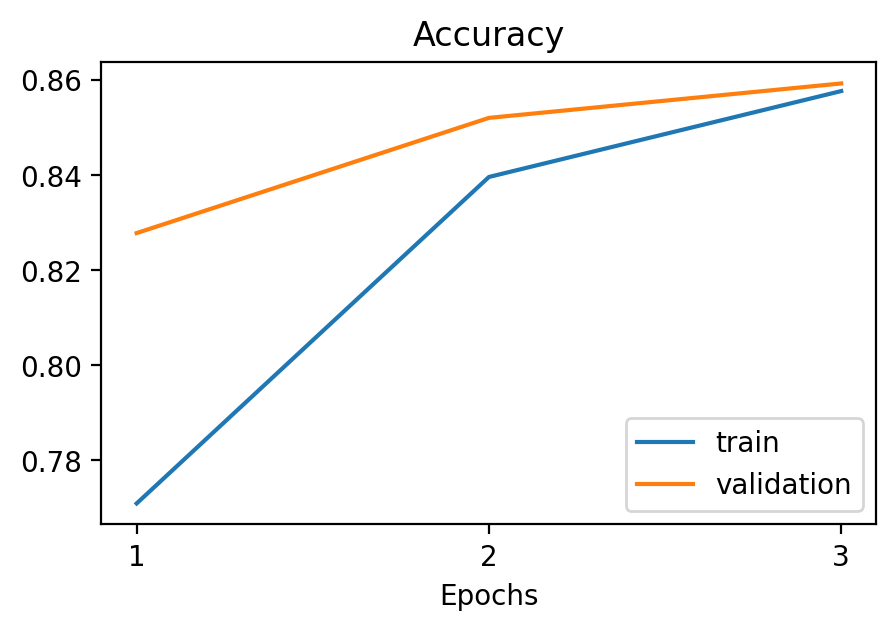

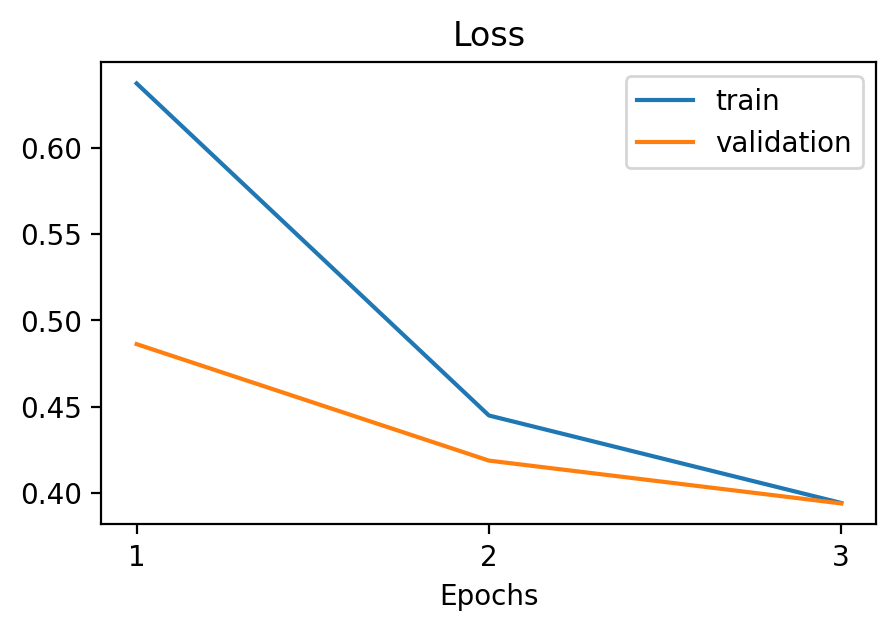

In [10]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)

# Plot Accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.xlabel('Epochs')
plt.xticks(epochs) 
plt.title('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

# Plot Loss
plt.figure(figsize=(5, 3))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epochs')
plt.xticks(epochs) 
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.show()

## Evaluate model on test set

### Accuracy

In [11]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", round(accuracy, 3))

Test accuracy: 0.851


### Precision, Recall and F1 Score

We use `classification_report` to evaluate the `precision`, `recall` and `f1_score`.  
Under the hood, the formulas of these metrics are as follows:  
<br>
$$
 precision = \frac{TP}{TP + FP} \\
 recall = \frac{TP}{TP + TN}\\
 F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times \frac{precision\times recall}{precision + recall}
$$
<br>
where TP = true positives, FP = false positives, and TN = true negatives

In [12]:
y_pred = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

print(classification_report(y_test, y_pred, target_names=category_list))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.79      0.80      1000
     Trouser       1.00      0.95      0.97      1000
    Pullover       0.71      0.83      0.76      1000
       Dress       0.85      0.87      0.86      1000
        Coat       0.69      0.83      0.75      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.70      0.43      0.53      1000
     Sneaker       0.91      0.96      0.93      1000
         Bag       0.90      0.97      0.94      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Save & load model

In [13]:
model.save("model/mnist_fashion_saved_model")

INFO:tensorflow:Assets written to: model/mnist_fashion_saved_model/assets


INFO:tensorflow:Assets written to: model/mnist_fashion_saved_model/assets


In [14]:
loaded_model = tf.keras.models.load_model("model/mnist_fashion_saved_model")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4